In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

c:\Users\esper\Desktop\injury_forecasting


In [2]:
from src.plotting import set_plot_style
from src.config import DATA_DIR, RESULTS_DIR
set_plot_style()

import pandas as pd


In [3]:
monthly_complete = pd.read_csv(DATA_DIR / "cleaned" / "cleaned_monthly_panel.csv", parse_dates=['Date'])



In [4]:
from src.features import build_panel_features

X_m, y_m, meta_m = build_panel_features(
    panel_df=monthly_complete,
    target="HospRisk",
    group_col="State",
    date_col="Date",
    freq="MS",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewm_spans=(3, 6, 12),
    dropna=True,
)

X_m.head(), y_m.head(), meta_m.head()

(   year  month  quarter  month_sin     month_cos  HospRisk_lag1  \
 0  2016      1        1   0.500000  8.660254e-01       0.604047   
 1  2016      2        1   0.866025  5.000000e-01       1.458312   
 2  2016      3        1   1.000000  6.123234e-17       0.854744   
 3  2016      4        2   0.866025 -5.000000e-01       0.854186   
 4  2016      5        2   0.500000 -8.660254e-01       1.052368   
 
    HospRisk_lag2  HospRisk_lag3  HospRisk_lag6  HospRisk_lag12  \
 0       0.907441       1.313065       1.268649        0.714760   
 1       0.604047       0.907441       1.164498        0.765072   
 2       1.458312       0.604047       0.758802        1.123538   
 3       0.854744       1.458312       1.313065        1.070064   
 4       0.854186       0.854744       0.907441        1.168046   
 
    HospRisk_rollmean3  HospRisk_rollmean6  HospRisk_rollmean12  HospRisk_ewm3  \
 0            0.941518            1.002750             0.993696       0.813459   
 1            0.989934

In [45]:
from src.RQ1_utils import (
    yearly_train_ends, 
    rolling_origin_masks,
    run_global,
    validate_predictions_basic,
    plot_fit_and_forecast,
    plot_residuals_distribution,
    plot_rmse_per_fold,
    plot_stability_across_splits,
    plot_delta_rmse_to_best_per_fold,
    summarize_metrics_mean_std,
    summarize_perm_importance,
    plot_perm_importance_bar,
)
    
    

In [8]:
train_ends = yearly_train_ends(meta_m, date_col="Date")
splits = rolling_origin_masks(meta_m, date_col="Date", train_ends=train_ends, test_size=12)

len(train_ends), len(splits)

(9, 8)

In [9]:
split_calendar = pd.DataFrame([
    {
        "train_end": s["train_end"].date(),
        "test_start": s["test_start"].date(),
        "test_end": s["test_end"].date(),
        "train_weeks": s["n_train_weeks"],
        "test_weeks": s["n_test_weeks"],
        "train_rows": s["n_train_rows"],
        "test_rows": s["n_test_rows"],
    }
    for s in splits
])

split_calendar.head(10)


,train_end,test_start,test_end,train_weeks,test_weeks,train_rows,test_rows
0,2016-12-01,2017-01-01,2017-12-01,12,12,360,360
1,2017-12-01,2018-01-01,2018-12-01,24,12,720,360
2,2018-12-01,2019-01-01,2019-12-01,36,12,1080,360
3,2019-12-01,2020-01-01,2020-12-01,48,12,1440,360
4,2020-12-01,2021-01-01,2021-12-01,60,12,1800,360
5,2021-12-01,2022-01-01,2022-12-01,72,12,2160,360
6,2022-12-01,2023-01-01,2023-12-01,84,12,2520,360
7,2023-12-01,2024-01-01,2024-12-01,96,12,2880,360


In [10]:
# train_end dates to keep
keep_train_ends = {
    pd.Timestamp("2018-12-01"),
    pd.Timestamp("2019-12-01"),
    pd.Timestamp("2020-12-01"),
    pd.Timestamp("2021-12-01"),
    pd.Timestamp("2022-12-01"),
    pd.Timestamp("2023-12-01"),
}

# filter splits
splits_origins = [
    s for s in splits
    if pd.Timestamp(s["train_end"]) in keep_train_ends
]

len(splits_origins), [s["train_end"].date() for s in splits_origins]


(6,
 [datetime.date(2018, 12, 1),
  datetime.date(2019, 12, 1),
  datetime.date(2020, 12, 1),
  datetime.date(2021, 12, 1),
  datetime.date(2022, 12, 1),
  datetime.date(2023, 12, 1)])

In [11]:
horizons = [1, 3, 6]

preds_m, metrics_m, perm_m = run_global(
    X=X_m,
    y=y_m,
    meta=meta_m,
    splits=splits_origins,
    horizons=horizons,
    group_col="State",
    date_col="Date",
    seasonal_period=12,
    use_linear=True,
    use_tree=True,
    compute_perm_importance=True,          
    savedir=RESULTS_DIR,          
    run_name="monthly_global_no_exg",
)


### Data validation

In [12]:
# how many TRAIN rows were stored per split/horizon/model
train_counts = (
    preds_m.query("set == 'train'")
          .groupby(["split_id", "train_end", "horizon", "model"])
          .size()
          .reset_index(name="n_rows")
)

# view one model only (easier to read), e.g. Ridge if present
train_counts[train_counts["model"].str.contains("Ridge", case=False, na=False)].sort_values(["train_end","horizon"])


,split_id,train_end,horizon,model,n_rows
5,1,2018-12-01,1,Ridge,1080
12,1,2018-12-01,3,Ridge,1080
19,1,2018-12-01,6,Ridge,1080
26,2,2019-12-01,1,Ridge,1440
33,2,2019-12-01,3,Ridge,1440
40,2,2019-12-01,6,Ridge,1440
47,3,2020-12-01,1,Ridge,1800
54,3,2020-12-01,3,Ridge,1800
61,3,2020-12-01,6,Ridge,1800
68,4,2021-12-01,1,Ridge,2160


In [13]:
metrics_m.query("set == 'test'").sort_values(["train_end","horizon","MASE"]).head(20)


,split_id,train_end,horizon,model,set,n_rows,MAE,RMSE,MASE
2,1,2018-12-01,1,Ridge,test,360,0.228079,0.305720,0.785216
14,1,2018-12-01,1,CatBoost,test,360,0.228470,0.308057,0.785330
4,1,2018-12-01,1,Lasso,test,360,0.227937,0.304479,0.785979
6,1,2018-12-01,1,ElasticNet,test,360,0.228296,0.305181,0.786880
12,1,2018-12-01,1,LightGBM,test,360,0.230513,0.307989,0.789180
8,1,2018-12-01,1,PLS,test,360,0.228699,0.304551,0.791693
10,1,2018-12-01,1,XGBoost,test,360,0.236793,0.318470,0.814878
0,1,2018-12-01,1,Seasonal Naive,test,360,0.302429,0.419733,0.990162
17,1,2018-12-01,3,Ridge,test,360,0.227157,0.310292,0.788019
21,1,2018-12-01,3,ElasticNet,test,360,0.227189,0.309466,0.790646


In [14]:
validate_predictions_basic(preds_m)

✓ Basic prediction validation passed.


In [15]:
preds_m['model'].value_counts()

model
Ridge             41820
Lasso             41820
ElasticNet        41820
PLS               41820
LightGBM          41820
XGBoost           41820
CatBoost          41820
Seasonal Naive     6180
Name: count, dtype: int64

In [16]:
def build_horizon_results_table(
    metrics_df: pd.DataFrame,
    horizon: int,
) -> pd.DataFrame:
    """

    split_year | model | train_RMSE | test_RMSE | test_MAE | test_MASE

    """

    df = metrics_df.query("horizon == @horizon").copy()
    df["split_year"] = pd.to_datetime(df["train_end"]).dt.year

    # TRAIN metrics
    train = (
        df.query("set == 'train'")
          .loc[:, ["split_year", "model", "RMSE"]]
          .rename(columns={"RMSE": "train_RMSE"})
    )

    # TEST metrics
    test = (
        df.query("set == 'test'")
          .loc[:, ["split_year", "model", "RMSE", "MAE", "MASE"]]
          .rename(columns={
              "RMSE": "test_RMSE",
              "MAE": "test_MAE",
              "MASE": "test_MASE",
          })
    )

    # Merge and order by split_year
    out = (
        train
        .merge(
            test,
            on=["split_year", "model"],
            how="inner",
            validate="one_to_one",
        )
        .sort_values(["split_year", "model"])
        .reset_index(drop=True)
    )

    return out


In [17]:
monthly_h1 = build_horizon_results_table(metrics_m, horizon=1)

monthly_h1


,split_year,model,train_RMSE,test_RMSE,test_MAE,test_MASE
0,2018,CatBoost,0.252311,0.308057,0.228470,0.785330
1,2018,ElasticNet,0.313058,0.305181,0.228296,0.786880
2,2018,Lasso,0.313327,0.304479,0.227937,0.785979
3,2018,LightGBM,0.230147,0.307989,0.230513,0.789180
4,2018,PLS,0.313357,0.304551,0.228699,0.791693
5,2018,Ridge,0.312561,0.305720,0.228079,0.785216
6,2018,XGBoost,0.200217,0.318470,0.236793,0.814878
7,2019,CatBoost,0.263255,0.310465,0.238580,0.843435
8,2019,ElasticNet,0.310717,0.301422,0.227613,0.790585
9,2019,Lasso,0.310911,0.301290,0.227629,0.791671


In [18]:
def summarize_metrics_mean_std(
    metrics_df: pd.DataFrame,
    horizon: int,
) -> pd.DataFrame:
    """
    Summarize TEST performance for a given horizon.
    
    Rows: models
    Columns: RMSE, MAE, MASE
    Values: mean ± std across splits
    """

    df = (
        metrics_df
        .query("set == 'test' and horizon == @horizon")
        .loc[:, ["model", "RMSE", "MAE", "MASE"]]
    )

    summary = (
        df
        .groupby("model")
        .agg(
            RMSE_mean=("RMSE", "mean"),
            RMSE_std=("RMSE", "std"),
            MAE_mean=("MAE", "mean"),
            MAE_std=("MAE", "std"),
            MASE_mean=("MASE", "mean"),
            MASE_std=("MASE", "std"),
        )
    )

    # format as mean ± std
    out = pd.DataFrame({
        "RMSE": summary.apply(
            lambda r: f"{r.RMSE_mean:.3f} ± {r.RMSE_std:.3f}", axis=1
        ),
        "MAE": summary.apply(
            lambda r: f"{r.MAE_mean:.3f} ± {r.MAE_std:.3f}", axis=1
        ),
        "MASE": summary.apply(
            lambda r: f"{r.MASE_mean:.3f} ± {r.MASE_std:.3f}", axis=1
        ),
    })

    return out.sort_index()


In [19]:
monthly_h1 = summarize_metrics_mean_std(metrics_m, horizon=1)


monthly_h1


,RMSE,MAE,MASE
model,,,
CatBoost,0.283 ± 0.022,0.206 ± 0.022,0.716 ± 0.082
ElasticNet,0.283 ± 0.022,0.207 ± 0.019,0.721 ± 0.065
Lasso,0.283 ± 0.021,0.207 ± 0.019,0.720 ± 0.065
LightGBM,0.284 ± 0.022,0.208 ± 0.022,0.724 ± 0.081
PLS,0.284 ± 0.022,0.208 ± 0.020,0.724 ± 0.067
Ridge,0.284 ± 0.022,0.207 ± 0.019,0.721 ± 0.065
Seasonal Naive,0.390 ± 0.037,0.276 ± 0.027,0.941 ± 0.083
XGBoost,0.289 ± 0.025,0.210 ± 0.024,0.728 ± 0.083


In [20]:
monthly_h3 = summarize_metrics_mean_std(metrics_m, horizon=3)
monthly_h3

,RMSE,MAE,MASE
model,,,
CatBoost,0.282 ± 0.027,0.205 ± 0.026,0.713 ± 0.090
ElasticNet,0.282 ± 0.023,0.205 ± 0.019,0.715 ± 0.060
Lasso,0.282 ± 0.022,0.204 ± 0.019,0.713 ± 0.061
LightGBM,0.287 ± 0.029,0.209 ± 0.028,0.727 ± 0.095
PLS,0.283 ± 0.023,0.205 ± 0.019,0.719 ± 0.061
Ridge,0.283 ± 0.023,0.205 ± 0.019,0.718 ± 0.058
Seasonal Naive,0.388 ± 0.036,0.275 ± 0.027,0.938 ± 0.088
XGBoost,0.290 ± 0.034,0.209 ± 0.030,0.730 ± 0.101


In [21]:
monthly_h6 = summarize_metrics_mean_std(metrics_m, horizon=6)
monthly_h6

,RMSE,MAE,MASE
model,,,
CatBoost,0.288 ± 0.031,0.209 ± 0.029,0.725 ± 0.105
ElasticNet,0.287 ± 0.021,0.210 ± 0.019,0.736 ± 0.067
Lasso,0.287 ± 0.021,0.210 ± 0.019,0.735 ± 0.067
LightGBM,0.290 ± 0.030,0.211 ± 0.028,0.732 ± 0.107
PLS,0.288 ± 0.021,0.210 ± 0.019,0.738 ± 0.067
Ridge,0.288 ± 0.021,0.210 ± 0.019,0.737 ± 0.066
Seasonal Naive,0.386 ± 0.031,0.272 ± 0.027,0.926 ± 0.092
XGBoost,0.294 ± 0.032,0.213 ± 0.030,0.738 ± 0.109


In [22]:
monthly_h1.to_csv(RESULTS_DIR / "monthly_metrics_h1.csv")
monthly_h3.to_csv(RESULTS_DIR / "monthly_metrics_h3.csv")
monthly_h6.to_csv(RESULTS_DIR / "monthly_metrics_h6.csv")

print(f"Saved monthly summary tables to {RESULTS_DIR.resolve()}")

Saved monthly summary tables to C:\Users\esper\Desktop\injury_forecasting\results


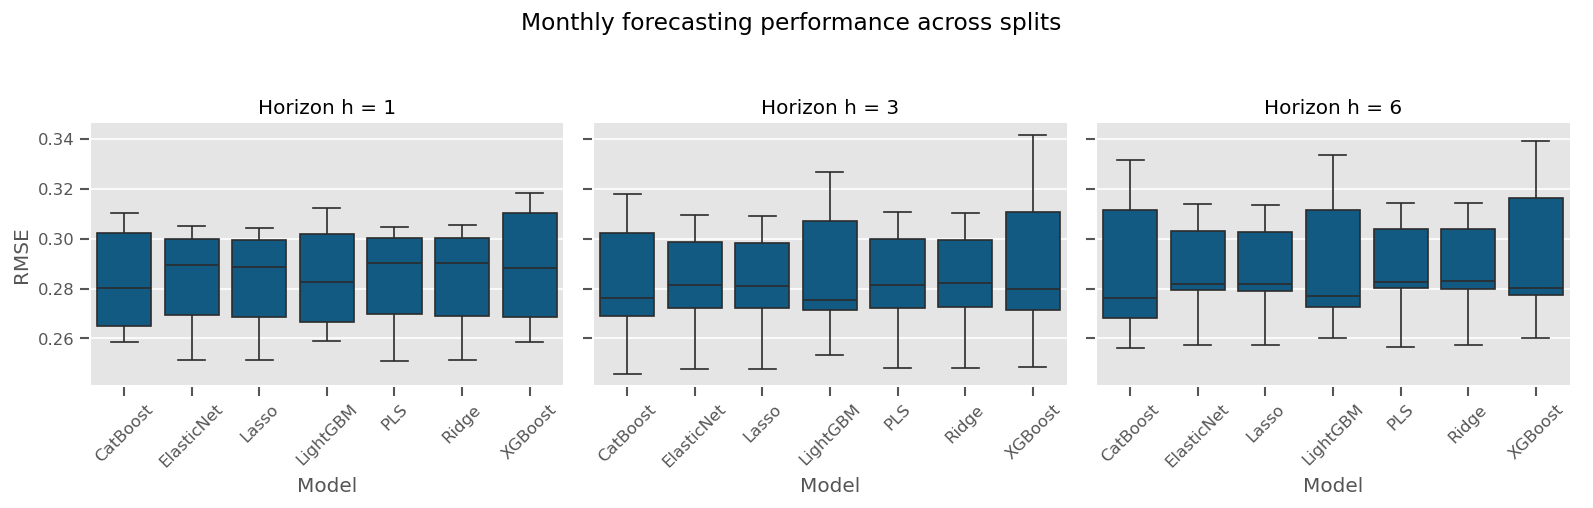

In [23]:
plot_stability_across_splits(
    metrics_m,
    metric="RMSE",
    aggregation="monthly",
)




In [24]:
(
    metrics_m
    .query("set == 'test' and horizon == 6")
    .groupby("model")["RMSE"]
    .agg(["mean", "median", "std"])
)


,mean,median,std
model,,,
CatBoost,0.288248,0.276331,0.030985
ElasticNet,0.287325,0.282017,0.021141
Lasso,0.287101,0.281698,0.021020
LightGBM,0.290378,0.277010,0.029836
PLS,0.287799,0.282655,0.021394
Ridge,0.287875,0.282938,0.021120
Seasonal Naive,0.386051,0.373612,0.030861
XGBoost,0.294098,0.280146,0.031876


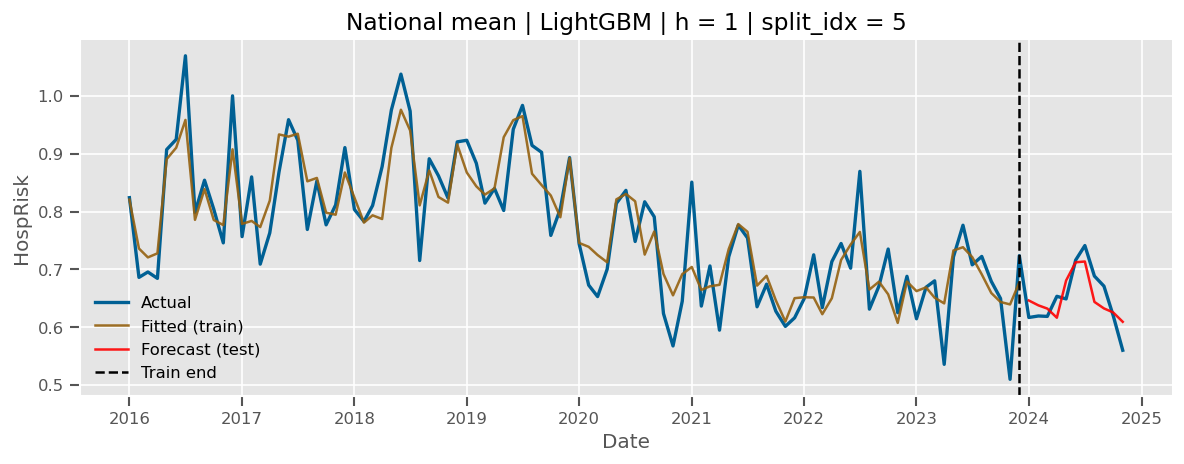

In [25]:
plot_fit_and_forecast(preds_m, model="LightGBM", split_idx=5, horizon=1)


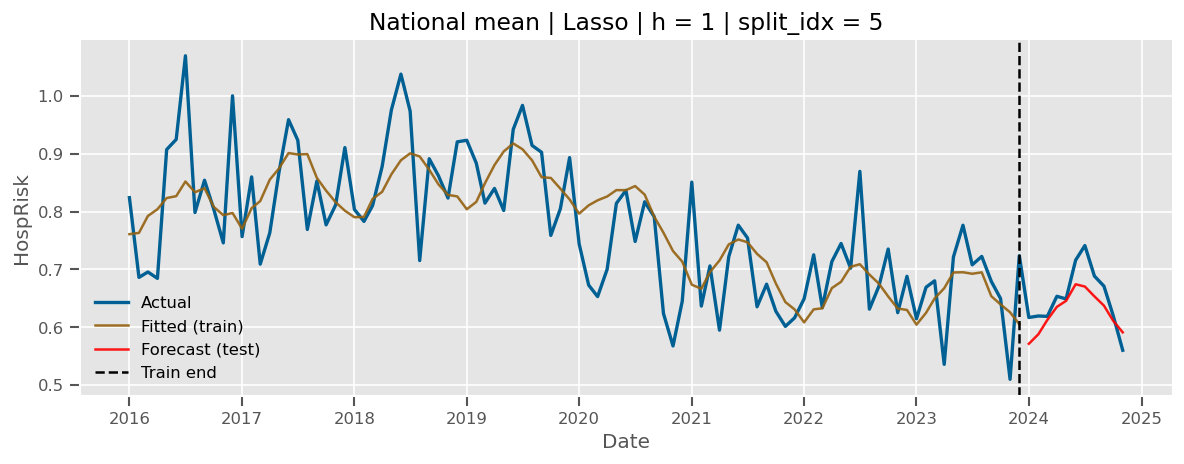

In [26]:
plot_fit_and_forecast(preds_m, model="Lasso", split_idx=5, horizon=1)

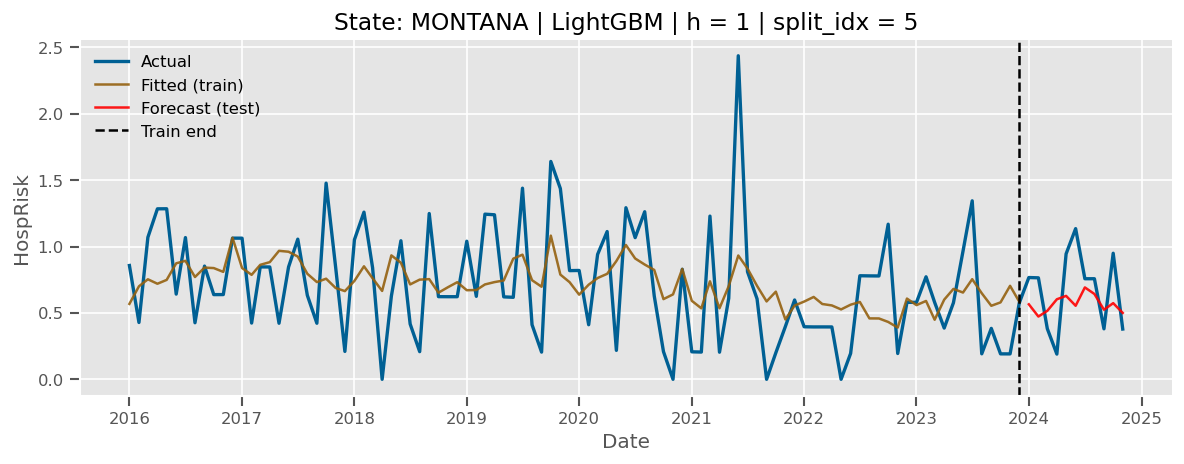

In [27]:
plot_fit_and_forecast(preds_m, model="LightGBM", split_idx=5, state='MONTANA', horizon=1)

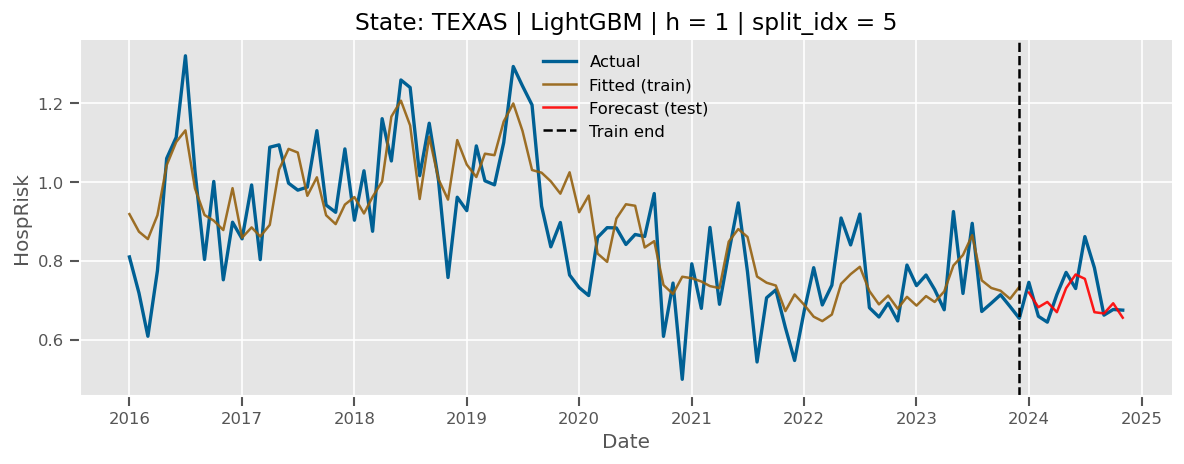

In [28]:
plot_fit_and_forecast(preds_m, model='LightGBM', split_idx=5, state='TEXAS', horizon=1)

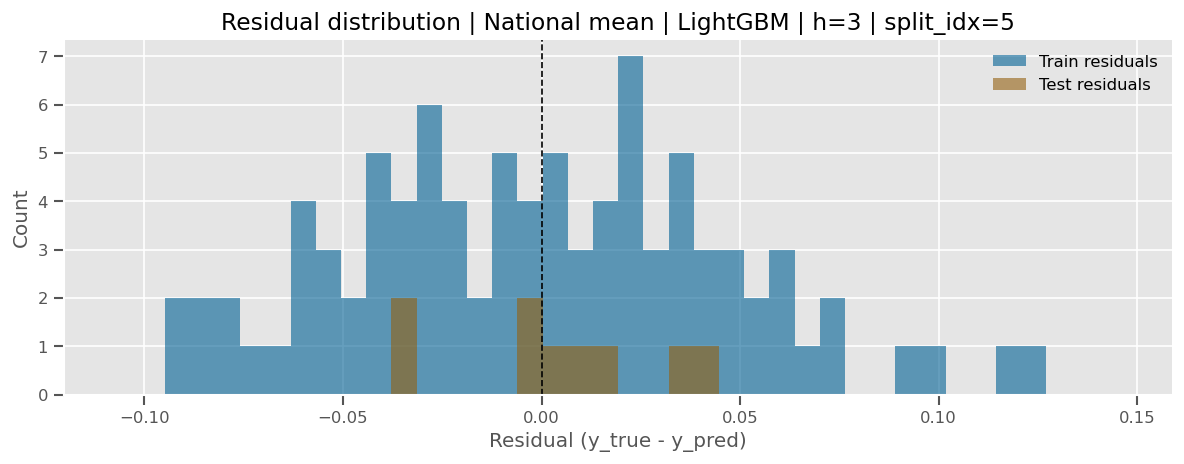

Train resid: mean=6.408e-10, std=0.05383
Test  resid: mean=0.002715, std=0.02542


In [29]:
plot_residuals_distribution(preds_m, model="LightGBM", split_idx=5, horizon=3)

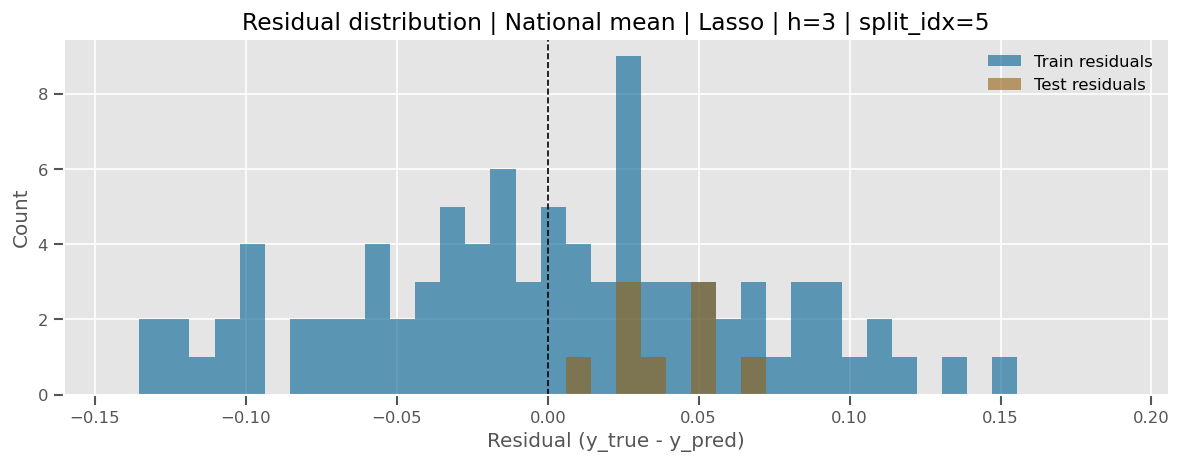

Train resid: mean=-7.748e-17, std=0.07362
Test  resid: mean=0.03886, std=0.01656


In [30]:
plot_residuals_distribution(preds_m, model='Lasso', split_idx=5, horizon=3)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np





In [31]:
from src.RQ1_utils import plot_ytrue_vs_ypred

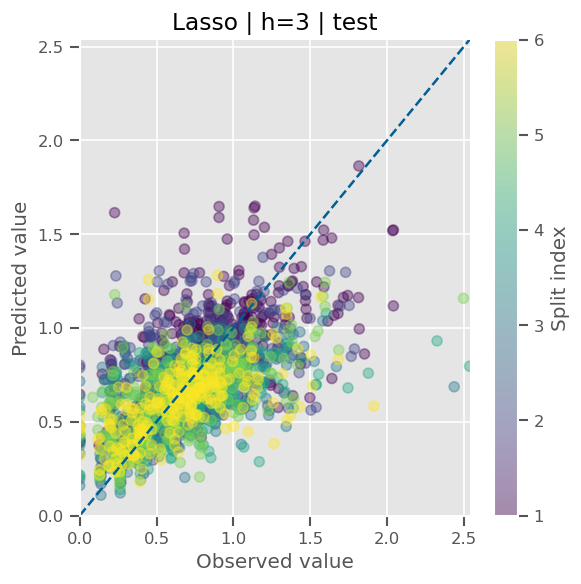

In [32]:
plot_ytrue_vs_ypred(preds_m, model='Lasso', horizon=3)

In [33]:
from src.RQ1_utils import plot_residuals_over_time

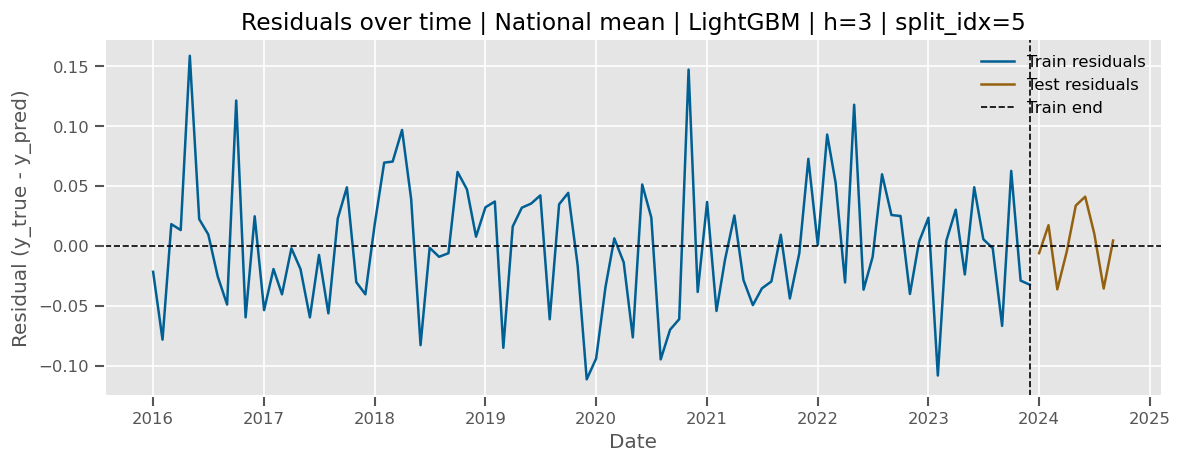

In [34]:
plot_residuals_over_time(preds_m, model="LightGBM", split_idx=5, horizon=3)

In [37]:
from src.RQ1_utils import plot_residuals_acf_national

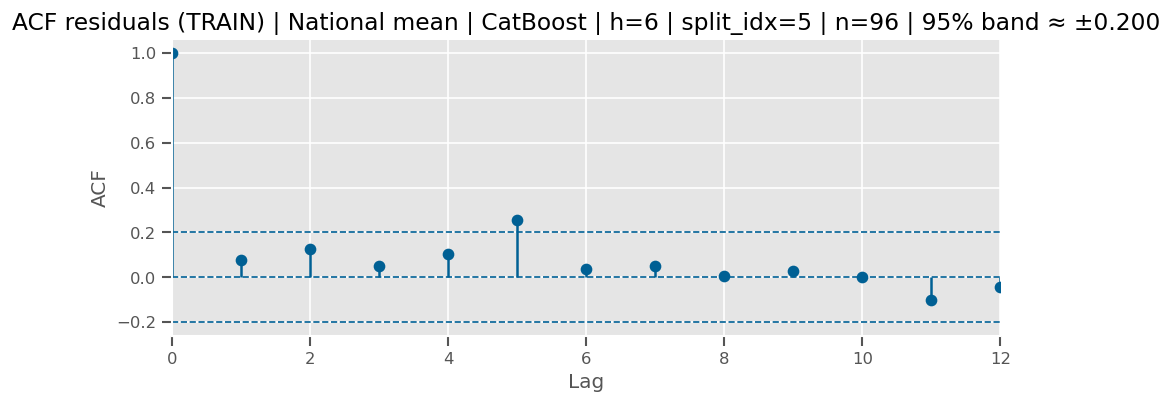

In [38]:
plot_residuals_acf_national(preds_m, model="CatBoost", split_idx=5, horizon=6, nlags=12)


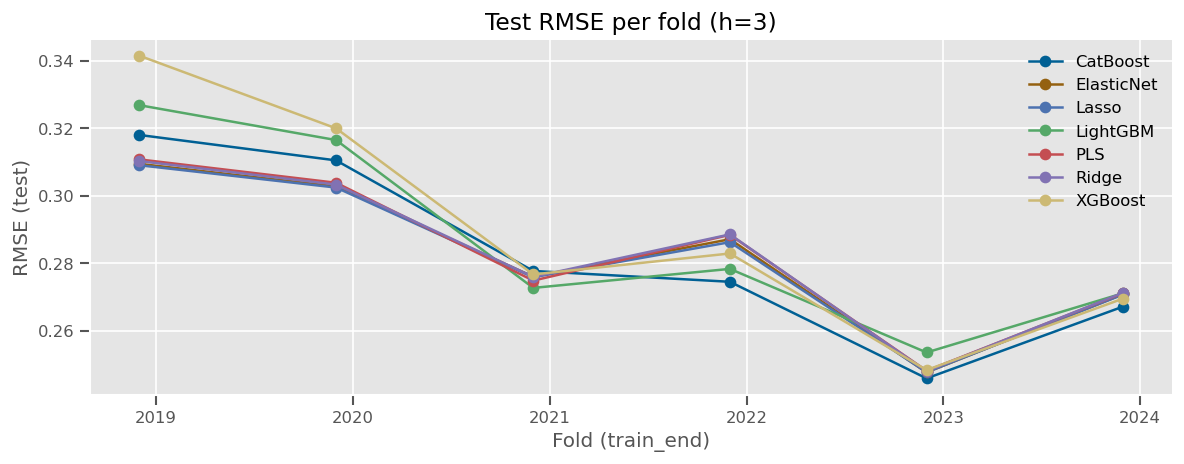

In [39]:
plot_rmse_per_fold(metrics_df=metrics_m, horizon=3)

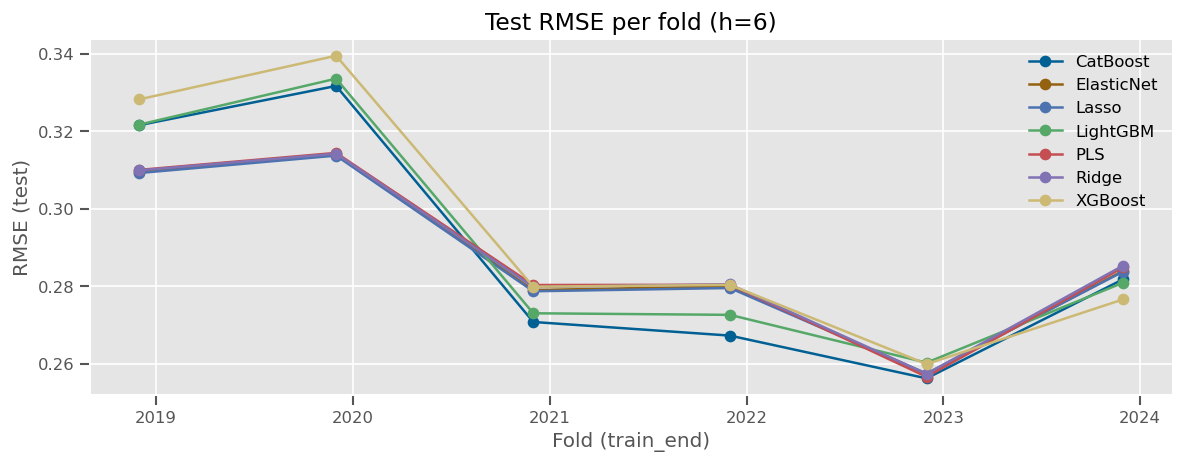

In [40]:
plot_rmse_per_fold(metrics_df=metrics_m, horizon=6)

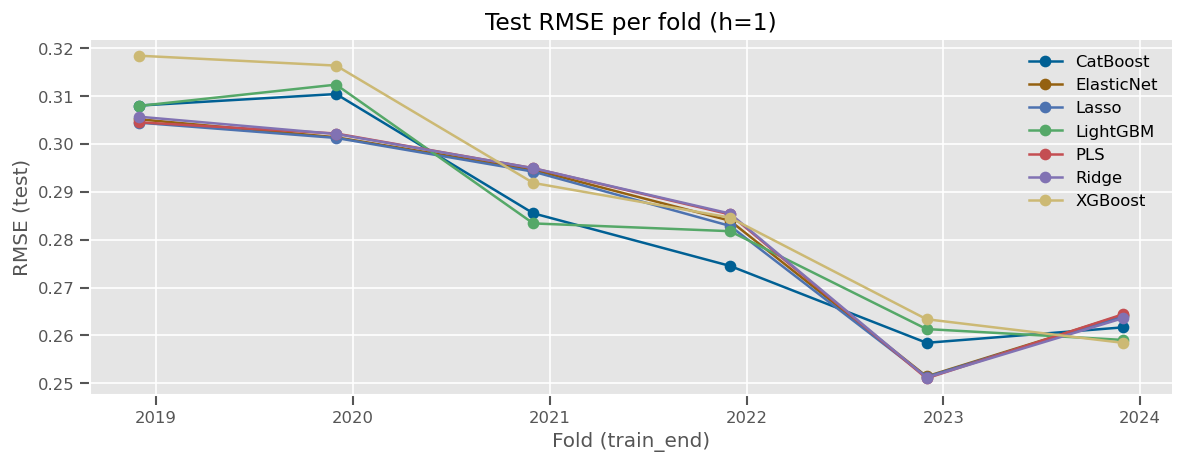

In [41]:
plot_rmse_per_fold(metrics_df=metrics_m, horizon=1)

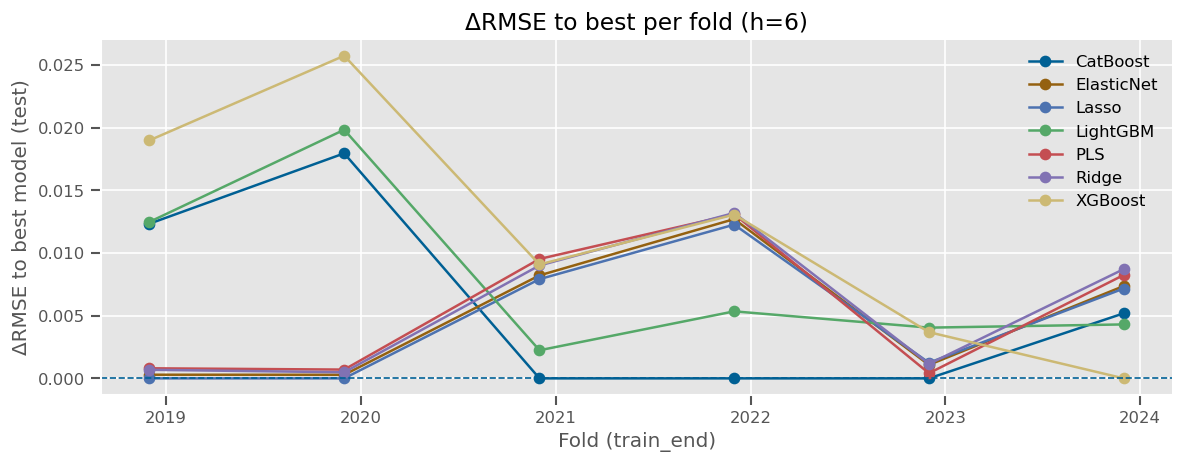

In [42]:
plot_delta_rmse_to_best_per_fold(metrics_df=metrics_m, horizon=6)

In [81]:
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def build_state_series(y_m, meta_m, date_col="Date", state_col="State"):
    df = meta_m[[date_col, state_col]].copy()
    df["y"] = y_m.values
    df[date_col] = pd.to_datetime(df[date_col])

    state_series = {}

    for state, g in df.groupby(state_col):
        # Ensure we normalize dates to the start of the month immediately
        g[date_col] = g[date_col].dt.to_period("M").dt.to_timestamp()
        
        s = g.groupby(date_col)["y"].mean().sort_index()

        # Enforce regular MS grid
        full_idx = pd.date_range(s.index.min(), s.index.max(), freq="MS")
        s = s.reindex(full_idx)

        if s.isna().any():
            s = s.interpolate(limit_direction="both")

        s = s.asfreq("MS")
        state_series[state] = s

    return state_series


def ets_panel_rolling_origin(
    state_series: dict,
    splits_origins: list[dict],
    meta_m: pd.DataFrame,
    horizons=(1, 3, 6),
    seasonal_periods=12,
    model_name="ETS(A,A,A)",
):
    rows = []
    meta_dates = pd.to_datetime(meta_m["Date"])

    for split in splits_origins:
        train_end = pd.to_datetime(split["train_end"])

        # FIX: Change to_timestamp("M") to to_timestamp() for Month Start alignment
        test_dates = (
            meta_dates.loc[split["test_mask"]]
            .dt.to_period("M")
            .dt.to_timestamp() # Defaults to 'S' (Start of period)
            .unique()
        )

        for state, series in state_series.items():
            for t in test_dates:
                # Check if the date exists in the series
                if t not in series.index:
                    continue

                # Use the date as the 'origin' for the forecast
                y_train = series.loc[:t]

                # ETS needs enough history (2 full cycles is a safe rule of thumb)
                if len(y_train.dropna()) < 2 * seasonal_periods:
                    continue

                try:
                    ets = ETSModel(
                        y_train,
                        error="add",
                        trend="add",
                        seasonal="add",
                        seasonal_periods=seasonal_periods,
                    )
                    fit = ets.fit(disp=False)
                except Exception:
                    continue

                for h in horizons:
                    # target_date will naturally land on Month Start because t is MS
                    target_date = t + pd.offsets.MonthBegin(h)

                    if target_date not in series.index:
                        continue
                    
                    if pd.isna(series.loc[target_date]):
                        continue

                    try:
                        # Forecast h steps ahead from origin t
                        yhat = float(fit.forecast(steps=h).iloc[-1])
                    except Exception:
                        continue

                    rows.append({
                        "State": state,
                        "Date": t,
                        "train_end": train_end,
                        "horizon": h,
                        "model": model_name,
                        "y_true": float(series.loc[target_date]),
                        "y_pred": yhat,
                    })

    return rows

In [82]:
state_series = build_state_series(y_m=y_m, meta_m=meta_m)

state_series


{'ALABAMA': 2016-01-01    1.458312
 2016-02-01    0.854744
 2016-03-01    0.854186
 2016-04-01    1.052368
 2016-05-01    1.052737
                 ...   
 2024-08-01    1.276848
 2024-09-01    0.501253
 2024-10-01    1.047407
 2024-11-01    0.910291
 2024-12-01    0.727174
 Freq: MS, Name: y, Length: 108, dtype: float64,
 'ARKANSAS': 2016-01-01    1.387642
 2016-02-01    0.977278
 2016-03-01    0.976483
 2016-04-01    0.975927
 2016-05-01    0.568736
                 ...   
 2024-08-01    0.731261
 2024-09-01    0.584924
 2024-10-01    1.093932
 2024-11-01    0.727220
 2024-12-01    0.871333
 Freq: MS, Name: y, Length: 108, dtype: float64,
 'COLORADO': 2016-01-01    0.621094
 2016-02-01    0.813575
 2016-03-01    0.812631
 2016-04-01    0.694954
 2016-05-01    0.812191
                 ...   
 2024-08-01    0.639042
 2024-09-01    0.302358
 2024-10-01    0.268917
 2024-11-01    0.604900
 2024-12-01    0.671795
 Freq: MS, Name: y, Length: 108, dtype: float64,
 'CONNECTICUT': 2016-01-01

In [83]:
ets_rows = ets_panel_rolling_origin(
    state_series=state_series,
    splits_origins=splits_origins,
    meta_m=meta_m,
    horizons=[1, 3, 6],
)

In [87]:
ets_df = pd.DataFrame(ets_rows)
ets_df

,State,Date,train_end,horizon,model,y_true,y_pred
0,ALABAMA,2019-01-01,2018-12-01,1,"ETS(A,A,A)",1.209190,1.002433
1,ALABAMA,2019-01-01,2018-12-01,3,"ETS(A,A,A)",1.541574,1.100488
2,ALABAMA,2019-01-01,2018-12-01,6,"ETS(A,A,A)",1.201750,1.637629
3,ALABAMA,2019-02-01,2018-12-01,1,"ETS(A,A,A)",1.062597,1.144377
4,ALABAMA,2019-02-01,2018-12-01,3,"ETS(A,A,A)",1.299764,1.536744
...,...,...,...,...,...,...,...
6175,WISCONSIN,2024-08-01,2023-12-01,3,"ETS(A,A,A)",0.688954,0.587529
6176,WISCONSIN,2024-09-01,2023-12-01,1,"ETS(A,A,A)",0.787893,0.699214
6177,WISCONSIN,2024-09-01,2023-12-01,3,"ETS(A,A,A)",0.721880,0.540050
6178,WISCONSIN,2024-10-01,2023-12-01,1,"ETS(A,A,A)",0.688954,0.594386


In [1]:
ets_df.to_csv(RESULTS_DIR / "monthly_ets_preds.csv")

NameError: name 'ets_df' is not defined

In [88]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

In [92]:
metrics_ets = (
    ets_df
    .groupby(["train_end", "horizon", "model"])
    .apply(lambda d: pd.Series({
        "RMSE": root_mean_squared_error(d["y_true"], d["y_pred"]),
        "MAE": mean_absolute_error(d["y_true"], d["y_pred"]),
        "n_obs": len(d),
    }))
    .reset_index()
)

metrics_ets.head()

C:\Users\esper\AppData\Local\Temp\ipykernel_31728\2834253448.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,train_end,horizon,model,RMSE,MAE,n_obs
0,2018-12-01,1,"ETS(A,A,A)",0.345104,0.255555,360.0
1,2018-12-01,3,"ETS(A,A,A)",0.353114,0.251619,360.0
2,2018-12-01,6,"ETS(A,A,A)",0.367128,0.262453,360.0
3,2019-12-01,1,"ETS(A,A,A)",0.350300,0.250295,360.0
4,2019-12-01,3,"ETS(A,A,A)",0.366968,0.270525,360.0


In [125]:
metrics_ets.to_csv(RESULTS_DIR / 'metrics_ets.csv', index=False)

In [96]:
metrics_m = pd.read_csv(RESULTS_DIR / "monthly_global_no_exg" / 'metrics.csv')
metrics_m

,split_id,train_end,horizon,model,set,n_rows,MAE,RMSE,MASE
0,1,2018-12-01,1,Seasonal Naive,test,360,0.302429,0.419733,0.990162
1,1,2018-12-01,1,Ridge,train,1080,0.224694,0.312561,0.763705
2,1,2018-12-01,1,Ridge,test,360,0.228079,0.305720,0.785216
3,1,2018-12-01,1,Lasso,train,1080,0.224824,0.313327,0.762941
4,1,2018-12-01,1,Lasso,test,360,0.227937,0.304479,0.785979
...,...,...,...,...,...,...,...,...,...
265,6,2023-12-01,6,XGBoost,test,180,0.201949,0.276651,0.699907
266,6,2023-12-01,6,LightGBM,train,2880,0.179845,0.247346,0.654349
267,6,2023-12-01,6,LightGBM,test,180,0.203521,0.280955,0.697240
268,6,2023-12-01,6,CatBoost,train,2880,0.193368,0.265466,0.699133


In [139]:
def get_ets_fold_metric(
    metrics_ets: pd.DataFrame,
    *,
    horizon: int,
    metric: str,
):
    """
    Returns a Series indexed by train_end with ETS metrics.
    """
    s = (
        metrics_ets
        .query("horizon == @horizon")
        .set_index("train_end")[metric]
        .sort_index()
    )
    return s


In [140]:
def get_ml_fold_metric(
    metrics_df: pd.DataFrame,
    *,
    model: str,
    horizon: int,
    metric: str,
):
    """
    Returns a Series indexed by train_end with TEST metrics for an ML model.
    """
    s = (
        metrics_df
        .query("set == 'test' and model == @model and horizon == @horizon")
        .set_index("train_end")[metric]
        .sort_index()
    )
    return s


In [143]:
s = get_ets_fold_metric(metrics_ets=metrics_ets, horizon=1, metric='RMSE')
s

train_end
2018-12-01    0.345104
2019-12-01    0.350300
2020-12-01    0.320890
2021-12-01    0.303291
2022-12-01    0.282104
2023-12-01    0.282244
Name: RMSE, dtype: float64

In [149]:
from scipy.stats import wilcoxon


def wilcoxon_test(
    metrics_ml: pd.DataFrame,
    metrics_ets: pd.DataFrame,
    *,
    ml_model: str,
    horizon: int,
    metric: str = "RMSE",
):
    """
    Paired Wilcoxon test comparing an ML model to ETS.
    """

    ml = get_ml_fold_metric(
        metrics_ml,
        model=ml_model,
        horizon=horizon,
        metric=metric,
    )

    ets = get_ets_fold_metric(
        metrics_ets,
        horizon=horizon,
        metric=metric,
    )

    # align on common folds
    df = pd.concat([ml, ets], axis=1, join="inner")
    df.columns = ["ml", "ets"]

    #if len(df) < 3:
    #    raise ValueError("Too few folds for a meaningful Wilcoxon test.")

    stat, p = wilcoxon(df["ml"], df["ets"], zero_method="wilcox")

    return {
        "n_folds": len(df),
        "statistic": stat,
        "p_value": p,
        "mean_diff": (df["ml"] - df["ets"]).mean(),
    }


In [145]:
s_ml = get_ml_fold_metric(metrics_m, model='CatBoost', horizon=1, metric='RMSE')

In [146]:
s_ml

train_end
2018-12-01    0.308057
2019-12-01    0.310465
2020-12-01    0.285532
2021-12-01    0.274544
2022-12-01    0.258464
2023-12-01    0.261698
Name: RMSE, dtype: float64

In [151]:
wilcoxon_test(
    metrics_ml=metrics_m,
    metrics_ets=metrics_ets,
    ml_model="CatBoost",
    horizon=3,
    metric="RMSE",
)


c:\Users\esper\anaconda3\Lib\site-packages\scipy\_lib\_util.py:1023: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)


{'n_folds': 0,
 'statistic': np.float64(nan),
 'p_value': np.float64(nan),
 'mean_diff': nan}

In [152]:
import pandas as pd
from scipy.stats import wilcoxon

def get_ml_fold_metric(metrics_df: pd.DataFrame, *, model: str, horizon: int, metric: str):
    df = metrics_df.copy()
    df["train_end"] = pd.to_datetime(df["train_end"])
    s = (
        df.query("set == 'test' and model == @model and horizon == @horizon")
          .groupby("train_end")[metric].mean()   # guards against duplicates
          .sort_index()
    )
    s.name = "ml"
    return s

def get_ets_fold_metric(metrics_ets: pd.DataFrame, *, horizon: int, metric: str):
    df = metrics_ets.copy()
    df["train_end"] = pd.to_datetime(df["train_end"])
    s = (
        df.query("horizon == @horizon")
          .groupby("train_end")[metric].mean()
          .sort_index()
    )
    s.name = "ets"
    return s

def wilcoxon_ml_vs_ets(metrics_ml: pd.DataFrame, metrics_ets: pd.DataFrame, *, ml_model: str, horizon: int, metric: str = "RMSE"):
    ml = get_ml_fold_metric(metrics_ml, model=ml_model, horizon=horizon, metric=metric)
    ets = get_ets_fold_metric(metrics_ets, horizon=horizon, metric=metric)

    aligned = pd.concat([ml, ets], axis=1, join="inner").dropna()

    # helpful debug info if alignment fails
    if aligned.empty:
        return {
            "n_folds": 0,
            "statistic": float("nan"),
            "p_value": float("nan"),
            "mean_diff": float("nan"),
            "ml_index_dtype": str(ml.index.dtype),
            "ets_index_dtype": str(ets.index.dtype),
            "ml_train_ends": [str(x) for x in ml.index.tolist()],
            "ets_train_ends": [str(x) for x in ets.index.tolist()],
        }

    stat, p = wilcoxon(aligned["ml"], aligned["ets"], zero_method="wilcox")
    return {
        "n_folds": int(len(aligned)),
        "statistic": float(stat),
        "p_value": float(p),
        "mean_diff": float((aligned["ml"] - aligned["ets"]).mean()),
    }


In [158]:
wilcoxon_ml_vs_ets(metrics_m, metrics_ets, ml_model="CatBoost", horizon=1, metric="RMSE")


{'n_folds': 6,
 'statistic': 0.0,
 'p_value': 0.03125,
 'mean_diff': -0.030862009513390753}

In [43]:
pi_ridge_h3 = summarize_perm_importance(
    perm_m,
    model="Ridge",
    horizon=3,
)


In [118]:
pi_ridge_h3

,mean_importance,std_importance,pos_frac
feature,,,
HospRisk_rollmean12,0.159836,0.098995,1.000000
quarter,0.065830,0.021571,1.000000
month,0.028847,0.009377,1.000000
HospRisk_rollmean6,0.024655,0.022914,1.000000
HospRisk_ewm12,0.021335,0.021549,0.833333
month_sin,0.015452,0.001683,1.000000
HospRisk_ewm3,0.009811,0.008365,0.833333
HospRisk_lag12,0.005966,0.005572,1.000000
month_cos,0.005269,0.002963,1.000000


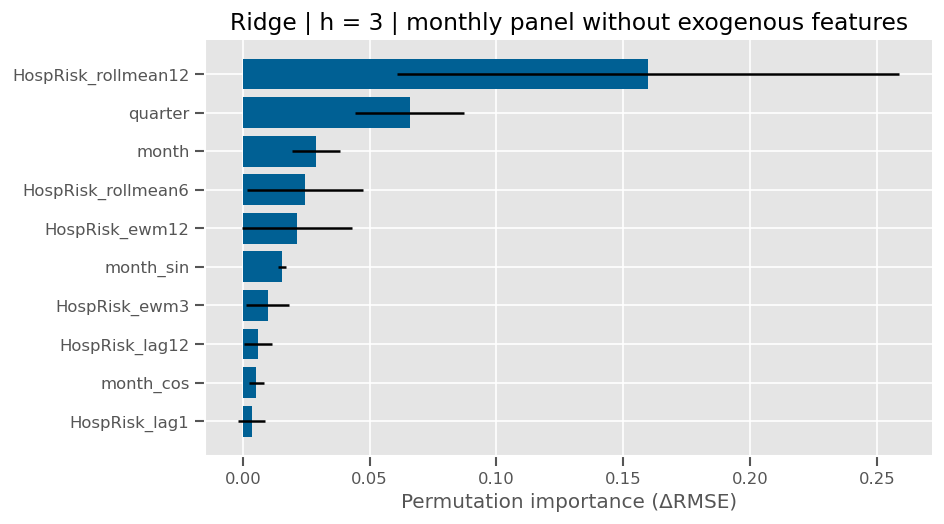

In [46]:
plot_perm_importance_bar(pi_ridge_h3, title='Ridge | h = 3 | monthly panel without exogenous features')

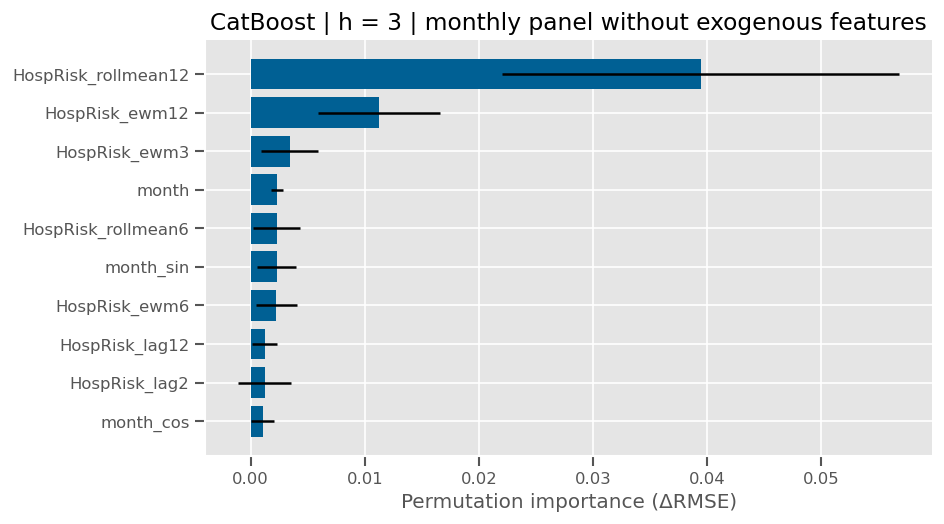

In [122]:
pi_catboost_h3 = summarize_perm_importance(
    perm_m,
    model="CatBoost",
    horizon=3,
)

plot_perm_importance_bar(pi_catboost_h3, title='CatBoost | h = 3 | monthly panel without exogenous features')


In [123]:
pi_catboost_h3

,mean_importance,std_importance,pos_frac
feature,,,
HospRisk_rollmean12,0.039462,0.017402,1.000000
HospRisk_ewm12,0.011242,0.005350,1.000000
HospRisk_ewm3,0.003402,0.002467,1.000000
month,0.002313,0.000519,1.000000
HospRisk_rollmean6,0.002274,0.002071,1.000000
month_sin,0.002273,0.001707,1.000000
HospRisk_ewm6,0.002257,0.001833,0.833333
HospRisk_lag12,0.001243,0.001096,0.833333
HospRisk_lag2,0.001210,0.002302,0.833333


In [126]:
def summarize_mean_sd_ets(
    metrics_ets: pd.DataFrame,
    *,
    horizon: int,
):
    """
    Summarize ETS metrics as mean ± sd across prequential folds.
    Rows: models
    Columns: RMSE, MAE
    """

    df = metrics_ets.query("horizon == @horizon").copy()

    summary = (
        df
        .groupby("model")[["RMSE", "MAE"]]
        .agg(["mean", "std"])
    )

    out = pd.DataFrame(index=summary.index)

    for metric in ["RMSE", "MAE"]:
        out[metric] = (
            summary[(metric, "mean")].round(3).astype(str)
            + " ± "
            + summary[(metric, "std")].round(3).astype(str)
        )

    return out


In [128]:
ets_m1 = summarize_mean_sd_ets(metrics_ets=metrics_ets, horizon=1)
ets_m3 = summarize_mean_sd_ets(metrics_ets=metrics_ets, horizon=3)
ets_m6 = summarize_mean_sd_ets(metrics_ets=metrics_ets, horizon=6)

ets_all = pd.concat([ets_m1, ets_m3, ets_m6])
ets_all

,RMSE,MAE
model,,
"ETS(A,A,A)",0.314 ± 0.03,0.225 ± 0.024
"ETS(A,A,A)",0.319 ± 0.037,0.228 ± 0.03
"ETS(A,A,A)",0.325 ± 0.045,0.231 ± 0.035
